1. Data Preparation  & Feature Engineering

In [165]:
import yfinance as yf
import pandas as pd

In [166]:
#combine monthly data
from functools import reduce
ma = pd.read_csv('data/monthly 10-yr expected inflation.csv')
mb = pd.read_csv('data/monthly 10-yr real interest rate.csv')
mc = pd.read_csv('data/monthly cpi.csv')
md = pd.read_csv('data/monthly federal fund rate.csv')
me = pd.read_csv('data/monthly unemployed rate.csv')
mdfs = [ma,mb,mc,md,me]
mdf = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), mdfs)
mdf = mdf.iloc[419:-1,:]
mdf

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE
419,1981-12-01,NaN,NaN,94.100,12.37,8.5
420,1982-01-01,6.197611,7.623742,94.400,13.22,8.6
421,1982-02-01,6.079232,7.656648,94.700,14.78,8.9
422,1982-03-01,5.648130,7.128993,94.700,14.68,9.0
423,1982-04-01,5.713188,7.408347,95.000,14.94,9.3
...,...,...,...,...,...,...
927,2024-04-01,2.342961,1.938194,313.207,5.33,3.9
928,2024-05-01,2.451501,2.103399,313.225,5.33,4.0
929,2024-06-01,2.367064,1.999567,313.049,5.33,4.1
930,2024-07-01,2.368186,2.048396,313.534,5.33,4.3


In [167]:
gdp = pd.read_csv('data\quarterly GDP.csv')
gdp = gdp.iloc[140:]
gdp.tail()

<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:1: SyntaxWarning: invalid escape sequence '\q'
C:\Users\85253\AppData\Local\Temp\ipykernel_10540\3643532624.py:1: SyntaxWarning: invalid escape sequence '\q'
  gdp = pd.read_csv('data\quarterly GDP.csv')


,DATE,GDP
305,2023-04-01,27063.012
306,2023-07-01,27610.128
307,2023-10-01,27956.998
308,2024-01-01,28269.174
309,2024-04-01,28652.337


In [168]:
#2024 Q3 gdp is missing, so the value is manually searched for instead
#According to the GDPNow model from Fred, the 2024 Q3 GDP growth is expected to be 2.9%
#https://www.atlantafed.org/cqer/research/gdpnow
missing = pd.DataFrame({'DATE':['2024-07-01'],'GDP':[28652.337*1.029]})
gdp = pd.concat([gdp,missing])
gdp.tail()

,DATE,GDP
306,2023-07-01,27610.128000
307,2023-10-01,27956.998000
308,2024-01-01,28269.174000
309,2024-04-01,28652.337000
0,2024-07-01,29483.254773


In [169]:
#merge gdp into mdf
mdf = pd.merge(mdf,gdp,on='DATE',how='outer')
mdf.tail()

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP
508,2024-04-01,2.342961,1.938194,313.207,5.33,3.9,28652.337000
509,2024-05-01,2.451501,2.103399,313.225,5.33,4.0,NaN
510,2024-06-01,2.367064,1.999567,313.049,5.33,4.1,NaN
511,2024-07-01,2.368186,2.048396,313.534,5.33,4.3,29483.254773
512,2024-08-01,2.164069,1.664190,314.121,5.33,4.2,NaN


In [170]:
#replace the null values of gdp with an estimated value using linear interpolation
mdf.GDP = mdf.GDP.interpolate()
mdf.tail()

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP
508,2024-04-01,2.342961,1.938194,313.207,5.33,3.9,28652.337000
509,2024-05-01,2.451501,2.103399,313.225,5.33,4.0,28929.309591
510,2024-06-01,2.367064,1.999567,313.049,5.33,4.1,29206.282182
511,2024-07-01,2.368186,2.048396,313.534,5.33,4.3,29483.254773
512,2024-08-01,2.164069,1.664190,314.121,5.33,4.2,29483.254773


In [171]:
#since most features here are usually released at the same time as the target, SP500 returns, same-month prediction is meaningless
#we need to use the data from previous month to predict the next-month returns, e.g. Apr GDP to predict May return
#a month is added here to sync with the target
def add1m(date):
    month = date.month
    year = date.year
    if month != 12:
        month += 1
    else:
        month = 1
        year += 1
    return date.replace(month=month, year=year)

In [172]:
mdf.DATE = pd.to_datetime(mdf.DATE)
mdf.DATE = mdf.DATE.apply(add1m)
mdf.head()

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP
0,1982-01-01,NaN,NaN,94.1,12.37,8.5,NaN
1,1982-02-01,6.197611,7.623742,94.4,13.22,8.6,3274.302000
2,1982-03-01,6.079232,7.656648,94.7,14.78,8.9,3293.525333
3,1982-04-01,5.648130,7.128993,94.7,14.68,9.0,3312.748667
4,1982-05-01,5.713188,7.408347,95.0,14.94,9.3,3331.972000


In [173]:
#change the date format
mdf.DATE = mdf.DATE.dt.to_period('M')
mdf.tail()

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP
508,2024-05,2.342961,1.938194,313.207,5.33,3.9,28652.337000
509,2024-06,2.451501,2.103399,313.225,5.33,4.0,28929.309591
510,2024-07,2.367064,1.999567,313.049,5.33,4.1,29206.282182
511,2024-08,2.368186,2.048396,313.534,5.33,4.3,29483.254773
512,2024-09,2.164069,1.664190,314.121,5.33,4.2,29483.254773


In [174]:
nfci = pd.read_csv('data\weekly NFCI.csv')
nfci.head()

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
C:\Users\85253\AppData\Local\Temp\ipykernel_10540\1704888299.py:1: SyntaxWarning: invalid escape sequence '\w'
  nfci = pd.read_csv('data\weekly NFCI.csv')


,DATE,NFCI
0,1971-01-08,0.65053
1,1971-01-15,0.68852
2,1971-01-22,0.73354
3,1971-01-29,0.78243
4,1971-02-05,0.83205


In [175]:
#when a model is deployed, it will be updated on 15th every month
#we expect to use the closest day for the prediction made on 16th for the end of a month
#since nfci data is updated weekly, the closest days are from 9th to 15th
def selected(day):
    if int(day[-2:])>8 and int(day[-2:])<16:
        return 1
    else: return None

In [176]:
nfci['cond'] = nfci.DATE.apply(selected)
nfci.head()

,DATE,NFCI,cond
0,1971-01-08,0.65053,NaN
1,1971-01-15,0.68852,1.0
2,1971-01-22,0.73354,NaN
3,1971-01-29,0.78243,NaN
4,1971-02-05,0.83205,NaN


In [177]:
nfci.dropna(inplace=True)
nfci.drop('cond', axis=1, inplace=True)
nfci.head()

,DATE,NFCI
1,1971-01-15,0.68852
5,1971-02-12,0.87833
9,1971-03-12,1.01799
13,1971-04-09,1.24542
18,1971-05-14,1.60988


In [178]:
nfci.DATE = pd.to_datetime(nfci.DATE)
nfci.DATE = nfci.DATE.dt.to_period('M')
nfci.head() 

,DATE,NFCI
1,1971-01,0.68852
5,1971-02,0.87833
9,1971-03,1.01799
13,1971-04,1.24542
18,1971-05,1.60988


In [179]:
#merge nfci into mdf
mdf = pd.merge(mdf,nfci,on='DATE',how='inner')
mdf.head()

,DATE,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI
0,1982-01,NaN,NaN,94.1,12.37,8.5,NaN,1.89648
1,1982-02,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193
2,1982-03,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219
3,1982-04,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164
4,1982-05,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438


In [198]:
#Download sp500 data
sp500 = yf.Ticker('^GSPC').history(period='max')
sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0


In [199]:
#dropping dividends and stock splits as they are useless here
#dropping open as well because there are some '0' values which are untracable
sp500.drop(['Open','Dividends','Stock Splits'],axis=1,inplace=True)
sp500.head()

,High,Low,Close,Volume
Date,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,0


In [200]:
#Get the first 15-day data for prediction
sp500_reset=sp500.reset_index()
sp500_15d = sp500_reset[sp500_reset.Date.dt.day <= 15]
#Get the aggregated high, low, close and volume of the 15-day data by max, min and mean
sp500_15dagg = sp500_15d.groupby([sp500_15d.Date.dt.to_period('M')]
                              ).agg({'High':'max','Low':'min','Close':'mean','Volume':'sum'})
sp500_15dagg.reset_index(inplace=True)
sp500_15dagg.columns = ['Date','15dH','15dL','15dC','15dV']
sp500_15dagg.head()

C:\Users\85253\AppData\Local\Temp\ipykernel_10540\3948944410.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sp500_15dagg = sp500_15d.groupby([sp500_15d.Date.dt.to_period('M')]


,Date,15dH,15dL,15dC,15dV
0,1928-01,17.760000,17.350000,17.551111,0
1,1928-02,17.629999,17.400000,17.487000,0
2,1928-03,18.070000,17.299999,17.719091,0
3,1928-04,19.730000,18.910000,19.233333,0
4,1928-05,20.440001,19.780001,20.190909,0


In [202]:
#getting monthly on-balance volume by 15th of each month
#since the early OBV values are inaccurate, the period is maximized to reduce the effect on the concerned time range in this project
sp500_15dagg['OBV'] = (sp500_15dagg['15dV'] * (((sp500_15dagg['15dC']-sp500_15dagg['15dC'].shift(1))>0).astype(int)*2-1)).cumsum()
sp500_15dagg.tail()

,Date,15dH,15dL,15dC,15dV,OBV
1156,2024-05,5311.759766,5011.049805,5179.954634,45089430000,2632698390000
1157,2024-06,5447.250000,5234.319824,5365.119971,36771210000,2669469600000
1158,2024-07,5666.939941,5446.529785,5570.316016,33347650000,2702817250000
1159,2024-08,5566.160156,5119.259766,5350.892800,46087500000,2656729750000
1160,2024-09,5636.270020,5402.620117,5522.589952,33358370000,2690088120000


In [203]:
#get the date in a numerical way
#we'd like to focus more on the latest 3 years, so a benchmark is set at 2021
sp500_15dagg['Date_N'] = sp500_15dagg.Date.dt.year + (sp500_15dagg.Date.dt.month - 1)*0.01*100/12 - 2021
sp500_15dagg.head()


,Date,15dH,15dL,15dC,15dV,OBV,Date_N
0,1928-01,17.760000,17.350000,17.551111,0,0,-93.000000
1,1928-02,17.629999,17.400000,17.487000,0,0,-92.916667
2,1928-03,18.070000,17.299999,17.719091,0,0,-92.833333
3,1928-04,19.730000,18.910000,19.233333,0,0,-92.750000
4,1928-05,20.440001,19.780001,20.190909,0,0,-92.666667


In [204]:
#merge sp500_15dagg and mdf as features
sp500_15dagg.rename(columns={'Date':'DATE'},inplace=True)
df = pd.merge(sp500_15dagg,mdf,on='DATE',how='inner')
df.head()

,DATE,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI
0,1982-01,123.720001,114.070000,118.028001,458320000,13145600000,-39.000000,NaN,NaN,94.1,12.37,8.5,NaN,1.89648
1,1982-02,119.809998,112.820000,115.773000,482290000,12663310000,-38.916667,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193
2,1982-03,114.800003,104.459999,109.920908,677580000,11985730000,-38.833333,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219
3,1982-04,117.120003,111.480003,115.485001,506350000,12492080000,-38.750000,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164
4,1982-05,119.919998,115.910004,118.330000,567060000,13059140000,-38.666667,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438


In [205]:
#get monthly close value (target)
target = sp500.resample('M').ffill()
target.reset_index(inplace=True)
target.Date = target.Date.dt.to_period('M')
target.rename(columns={'Date':'DATE'},inplace=True)
target.drop(['High','Low','Volume'],axis=1,inplace=True)
target.head()

C:\Users\85253\AppData\Local\Temp\ipykernel_10540\2300570563.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  target = sp500.resample('M').ffill()
C:\Users\85253\AppData\Local\Temp\ipykernel_10540\2300570563.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  target.Date = target.Date.dt.to_period('M')


,DATE,Close
0,1927-12,17.660000
1,1928-01,17.570000
2,1928-02,17.260000
3,1928-03,19.280001
4,1928-04,19.750000


In [206]:
#merge features and target
df1 = pd.merge(df,target,on='DATE',how='inner')
df1.dropna(inplace=True)
df1.head()

,DATE,15dH,15dL,15dC,15dV,OBV,Date_N,EXPINF10YR,REAINTRATREARAT10Y,CPIAUCSL,FEDFUNDS,UNRATE,GDP,NFCI,Close
1,1982-02,119.809998,112.820000,115.773000,482290000,12663310000,-38.916667,6.197611,7.623742,94.4,13.22,8.6,3274.302000,1.94193,113.110001
2,1982-03,114.800003,104.459999,109.920908,677580000,11985730000,-38.833333,6.079232,7.656648,94.7,14.78,8.9,3293.525333,2.09219,111.959999
3,1982-04,117.120003,111.480003,115.485001,506350000,12492080000,-38.750000,5.648130,7.128993,94.7,14.68,9.0,3312.748667,2.17164,116.440002
4,1982-05,119.919998,115.910004,118.330000,567060000,13059140000,-38.666667,5.713188,7.408347,95.0,14.94,9.3,3331.972000,2.38438,111.879997
5,1982-06,112.480003,108.529999,110.446363,535280000,12523860000,-38.583333,5.689980,7.320041,95.9,14.45,9.4,3343.422000,2.80708,109.610001


2. EDA

In [207]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

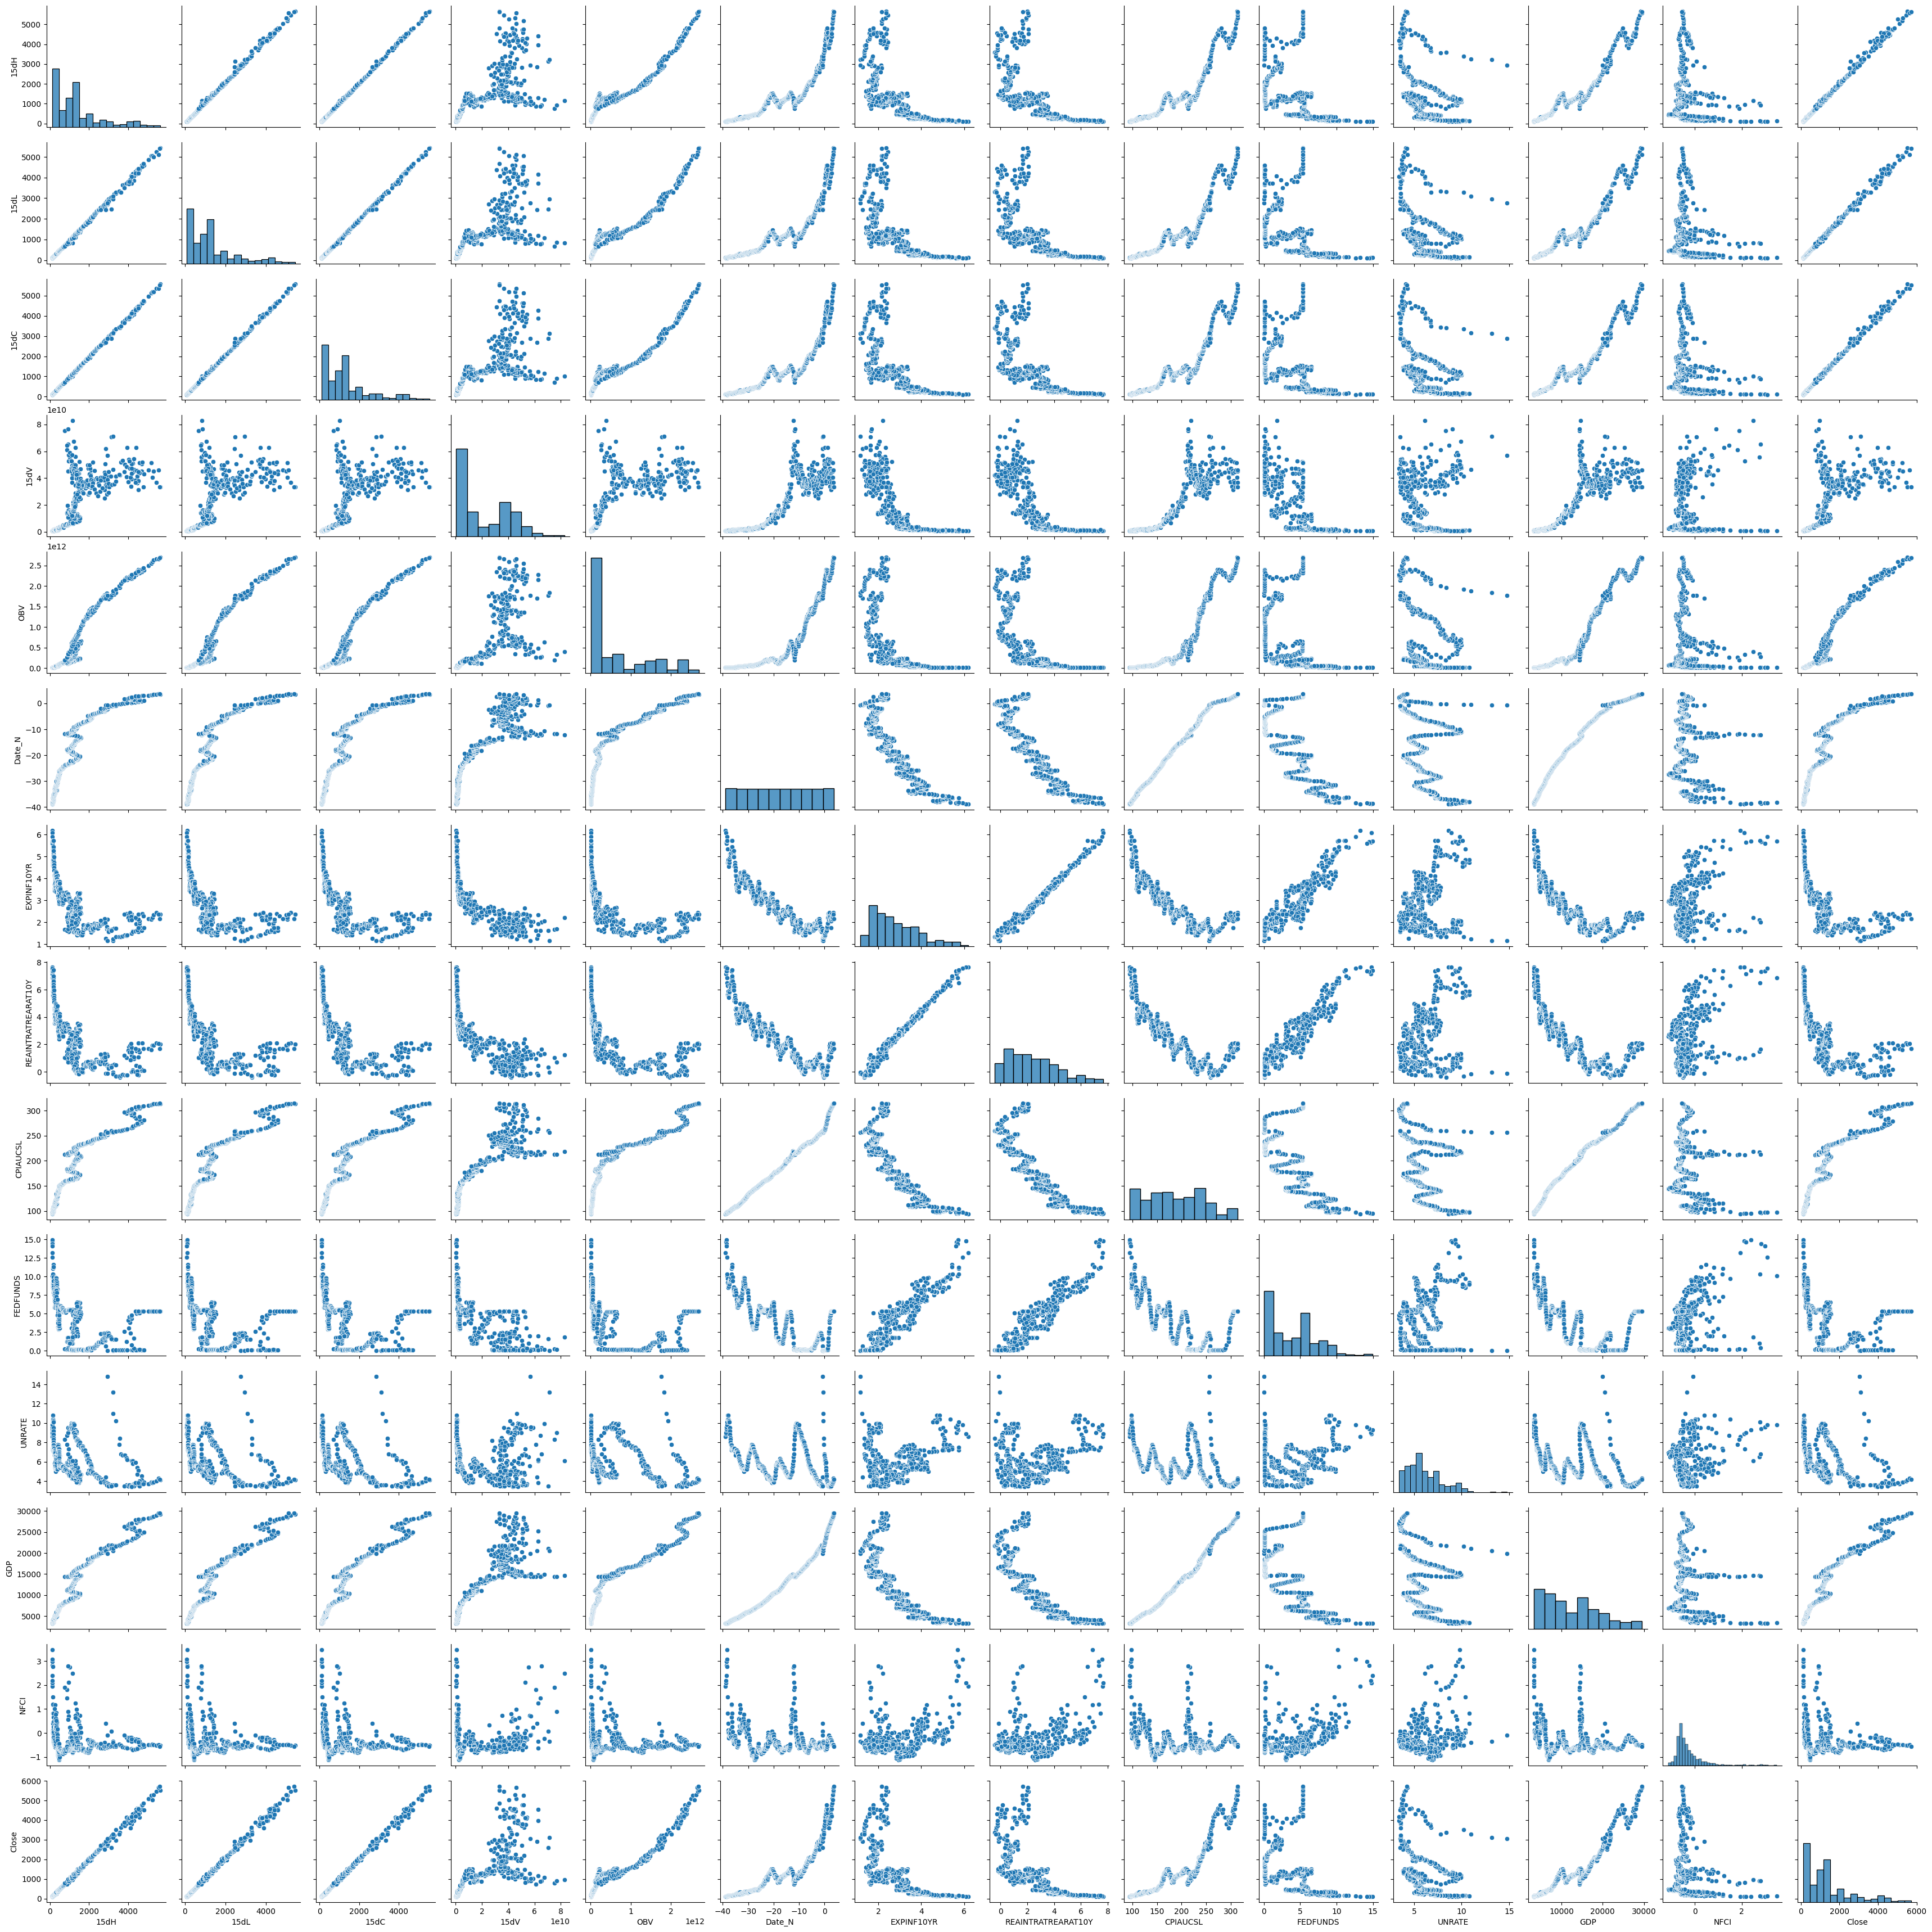

In [208]:
#correlation overview
plots = sns.pairplot(df1)
plt.show()

The bottom row indicates the correlations of different features when plotted against the target (Close), giving us the insights of the fitting algorithms for different features:
1. 15dH, 15fL and 15dC exhibits a linear correlationship with target. They will be fit for a linear regression model.
2. Date_N, CPIAUCSL, EXPINF10YR and GDP kind of follow an exponential trend. They will be fit for an exponential regression model.
3. All other features seem to be weak on correlations. All features will thus be fed in an XGBoost model.

Besides the scatter plots shown above, a line graph showing the close values in each month from recent years is also needed. The graph is plotted in Tableau for convenience and the result is shown below:

<img src="Monthly Closes in Different Years.png" width=800px height=400px />

As seen, the graph does not showcase many meaningful insights in a sense: we cannot tell whether the point will rise or drop in a specific month, nor can we catch any similar pattern in the trends of different years. As a result, we decided not to include 'Month' as a feature in this project. 

In [158]:
df1.to_csv('sp500_dataset.csv')